# Implementation of DynamicUnet 
---
step by step walkthrough of the implementation of a dynamic_unet that can use any backbone

In [1]:
from fastai2.vision.all import *

## Data

In [2]:
path = untar_data(URLs.CAMVID)

In [3]:
Path.BASE_PATH = path
path.ls()

(#5) [Path('codes.txt'),Path('images'),Path('valid.txt'),Path('models'),Path('labels')]

In [4]:
val_files = (path/'valid.txt').read().split('\n')

In [5]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [6]:
def get_y(f): return path/'labels'/f'{f.stem}_P{f.suffix}'

In [7]:
def ListSplitter(val_items):
    def _inner(o):
        val_mask = tensor([f.name in val_items for f in o])
        return [~val_mask, val_mask]
    return _inner

In [8]:
dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes)),
    get_items=get_image_files,
    get_y=get_y,
    splitter=ListSplitter(val_files),
    batch_tfms=[*aug_transforms(size=(360, 480)),
                Normalize.from_stats(*imagenet_stats)])
    

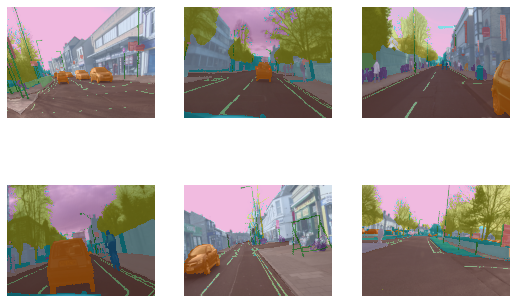

In [9]:
dls = dblock.dataloaders(path/'images', bs=8)
dls.show_batch(nrows=2, ncols=3)

In [10]:
dls.vocab = codes

In [11]:
n_classes = get_c(dls)

## DynamicUnet Steps

### Step 1: Create the encoder
---
For this we use a pretrained resnet34 as the encoder

In [12]:
model = resnet34(pretrained=True)

The pretrained model still has the last fully connected layer which we have to remove.

In [13]:
model_meta[resnet34]

{'cut': -2,
 'split': <function fastai2.vision.learner._resnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

In [14]:
cut = model_meta[resnet34].get('cut')

The `cut` property tells us the index we have to slice from

In [15]:
encoder = nn.Sequential(*list(model.children())[:cut])

In [16]:
encoder

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

The same thing can be done by using the `create_body` function in fastai

In [17]:
# additionaly if your input images are not 3-channel images, you can specify
# that using the n_in parameter to change the first layer appropriately
encoder = create_body(resnet34, cut=cut)

### Step 2: Perform a single pass through the encoder to get the indexes of the layers immediately before the layers that change the size of the input image.
---
We want to find the layers that are before either a max pooling or stride 2 covolution resulting in the reduction in the size of the input. The output of these layers will be used for the skip connections. For eg. in the original unet architecture below there are skip connections before each max pooling layer. 

![Unet Architecture](u-net-architecture.png)

In [18]:
# get the shape of the input images
imsize = dls.train.one_batch()[0].shape[-2:]

In [19]:
imsize

torch.Size([360, 480])

We will use hooks to store the outputs of each layer.

In [20]:
class Hook():
    def __init__(self, m, detach=True):
        self.detach = detach
        self.hook = m.register_forward_hook(self.hook_func)
    def remove(self):
        self.hook.remove()
    def hook_func(self, m, i, o):
        self.stored = o.detach().clone() if self.detach else o
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()

We create a hooks class that creates a hook for each module in our encoder.

In [21]:
class Hooks():
    def __init__(self, ms, detach=True):
        self.hooks = [Hook(m, detach) for m in ms]
    def remove(self):
        for hook in self.hooks: hook.remove()
    def __getitem__(self, i): return self.hooks[i]
    def __iter__(self):       return iter(self.hooks)
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()

In [22]:
# create a dummy input
inp = torch.randn(1,3,*imsize)
inp.shape

torch.Size([1, 3, 360, 480])

perform a single pass through the encoder to get the output shapes

In [23]:
with Hooks(encoder) as hooks:
    with torch.no_grad():
        _ = encoder.eval()(inp)
    sizes = [hook.stored.shape for hook in hooks]

In [24]:
sizes

[torch.Size([1, 64, 180, 240]),
 torch.Size([1, 64, 180, 240]),
 torch.Size([1, 64, 180, 240]),
 torch.Size([1, 64, 90, 120]),
 torch.Size([1, 64, 90, 120]),
 torch.Size([1, 128, 45, 60]),
 torch.Size([1, 256, 23, 30]),
 torch.Size([1, 512, 12, 15])]

We will perform the comparison only with the widths for simplicity. A change in the width also implies in the height.

In [25]:
widths = [size[-1] for size in sizes]
widths

[240, 240, 240, 120, 120, 60, 30, 15]

Find the indexes of the layers before a max pooling or stride 2 convolution

In [26]:
chg_idxs = list(np.where(np.array(widths[:-1]) != np.array(widths[1:]))[0])
chg_idxs

[2, 4, 5, 6]

In [27]:
# # we move in the reverse direction during upsampling
chg_idxs = list(reversed(chg_idxs))
chg_idxs

[6, 5, 4, 2]

### Step 3: Attach hooks to encoder at the indexes found in step 2
---
We need these hooks to store the outputs of those layers for use later in the upsampling path. The outputs of those layers would be concatenated with the results of the upsampling.

register the hooks

In [28]:
up_hooks = Hooks([encoder[i] for i in chg_idxs], detach=True)

### Step 4: Attach middle layers to encoder
---
The encoder forms the downsampling path (the red circle in the image below, whiles the decoder is the green circle. We need to define the layers circled in blue and attach them to the encoder.

![blocks in unet](u-net-architecture-mid.jpg)

In [29]:
# get the number of feature maps in the output of the encoder
n_c = sizes[-1][1]
n_c

512

In [37]:
mid_layers = nn.Sequential(ConvLayer(n_c, n_c//2, norm_type=None),
                           ConvLayer(n_c//2, n_c, norm_type=None)).eval()

mid_layers

Sequential(
  (0): ConvLayer(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
)

### Step 5: Define the decoder

At step of the decoder, we need to know the number of feature maps in the output of the last layer in other to rightly define the next layer. We need to perform a single pass through each new block to be able to keep track of the number of feature maps.

DecoderBlock is just a simplified version of UnetBlock in fastai. A block performs an upsampling using PixleShuffle with ICNR initialization followed by two 3x3 convolutions.

In [48]:
class DecoderBlock(Module):
    def __init__(self, up_channels, hook_output_channels, hook, final_div=True):
        self.hook = hook
        self.shuf = PixelShuffle_ICNR(up_channels, up_channels//2)
        self.bn = BatchNorm(hook_output_channels)
        
        ni = up_channels//2 + hook_output_channels
        nf = ni if final_div else ni//2
        self.conv1 = ConvLayer(ni, nf, norm_type=None)
        self.conv2 = ConvLayer(nf, nf, norm_type=None)
        
        self.act = nn.ReLU()
        
    def forward(self, x):
        hook_output = self.hook.stored
        # perform upsampling
        up = self.shuf(x)
        if up.shape[-2:] != hook_output.shape[-2:]:
            up = F.interpolate(up, hook_output.shape[-2:], mode='nearest')
        cat = self.act(torch.cat([up, self.bn(hook_output)], dim=1))
        return self.conv2(self.conv1(cat))

We will create  a decoder block for each of the layers in the encoder to which we've attached the hooks

In [54]:
class SimpleDynamicUnet(SequentialEx):
    def __init__(self, encoder, middle_layers, hooks, chg_idxs, sizes,
                 imsize, n_classes, last_cross=True):
        # fastai adds a batchnorm and relu in between the encoder and the middle layers
        n_c = sizes[-1][1]
        layers = [encoder, BatchNorm(n_c), nn.ReLU(), mid_layers]
        
        # create a dummy input
        inp = torch.randn(1,3,*imsize)
        # pass input through the encoder
        x = encoder.eval()(inp)
        x = mid_layers(x)

        for i, idx in enumerate(chg_idxs):
            not_final = i != len(chg_idxs) - 1
            up_channels = x.shape[1]
            hook_output_channels = sizes[idx][1]
   
            block = DecoderBlock(up_channels, hook_output_channels, hooks[i], not_final)
            layers.append(block)
            x = block(x)
            
        ni = x.shape[1]
        # ie. the shape of the output does not match the shape of the output of the first layer in the encoder
        if imsize != sizes[0][-2:]:
            layers.append(PixelShuffle_ICNR(ni))
            
        # concatenate the original input to the current output if last_cross is true
        if last_cross: 
            layers.append(MergeLayer(dense=True))
            ni += 3 # ie. the number of channels have now increased by 3
            layers.append(ResBlock(1, ni, ni))
        
        # add a 1x1 convolution layer 
        layers.append(ConvLayer(ni, n_classes, ks=1, act_cls=None, norm_type=None))
        
        super().__init__(*layers)

In [55]:
model = SimpleDynamicUnet(encoder, mid_layers, up_hooks, chg_idxs, sizes,
                          imsize, n_classes)

In [56]:
model

SimpleDynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps

compare with results of using unet_learner

In [52]:
learn = unet_learner(dls, resnet34, metrics=accuracy)

In [53]:
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05